__Import packages, configure pandas, and open database connection__

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

# disable pandas scientific notation
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# establish connection to database
db = sql.connect("/home/seacow/Desktop/Github Files/baseball.sqlite")

__Temporary tables created for this Assignment__

In [2]:
# get the data with total salary of teams in different years
# the data is sorted by the amount of payroll in descending order
# the data is created as a temporary table in the database
db.execute("""
    CREATE TEMPORARY TABLE payroll AS
        SELECT 
            l.yearid, 
            l.teamid, 
            r.name, 
            l.payroll 
        FROM
            (
            SELECT 
                yearid, teamid, SUM(salary) AS payroll 
            FROM
                salaries
            WHERE 
                yearid BETWEEN 2006 AND 2016
            GROUP BY 
                yearid, teamid
            ORDER BY 
                payroll DESC
            ) AS l
            LEFT JOIN 
                teams AS r
            ON
                l.teamid = r.teamid AND l.yearid = r.yearid
""")

db.commit()

In [3]:
# seperate payroll info for top 5 team and other team
db.execute("""
    CREATE TEMPORARY TABLE byteam AS
        SELECT 
            yearid, payroll, name,
        CASE
        WHEN 
            name IN ('New York Yankees', 
                     'Los Angeles Dodgers', 
                     'Detroit Tigers', 
                     'Boston Red Sox', 
                     'Philadelphia Phillies')
        THEN 
            'top5'
        ELSE
            'other_team'
        END class
        FROM
            payroll
""")

db.commit()

__Function built for this assignment__

In [4]:
# function to make path and regression plot
def makeplot(x, y, data, title, xlabel, ylabel, plot = 'line', regplot = False, cate_var = False, order = 1):
    '''
    NOTE: this funtion can only make path plot
    parameters:
    x: variable on x-axis
    y: variable on y-axis
    data: The dataset user wants to plot
    plot: type of plot (line or bar) default value is line plot
    title: The string that user wants to put in the title of the plot
    xlabel: specify label on x-axis
    ylabel: specify label on y-axis
    regplot: A boolean argument that specifies whether user wants a regression plot to be made
    cate_val: A boolean argument that specifies if the plot should be seperated by any 
    categorical variable
    order: takes in integer that sepcifies the order of the regression model
    '''
    plt.figure(figsize=(11,8))
    
    if plot == "line":
        # check if user wants to seperate graph by categorical variable
        if cate_var:
            plot = sns.lineplot(x, y, hue = cate_var, data = data)
            plot.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
        else:
            plot = sns.lineplot(x, y, data = data)
    else:
        plot = sns.barplot(x, y, data = data)
    
    # add title and labels
    plot.set_title(title, y = 1.1)
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel)
    
    # make regression plot if needed
    if regplot:
        lm_plot = sns.lmplot(x, y, data, order = order, height = 6.4, aspect = 1.5)
        lm_plot.axes[0,0].set_xlabel(xlabel)
        lm_plot.axes[0,0].set_ylabel(ylabel)
        lm_plot.fig.suptitle("Regression Model of " + title)
        lm_plot.fig.subplots_adjust(top = 0.9)
        return(plot, lm_plot)
    
    return(plot)

In [5]:
# function to display table side by side
# originial author: Eric Moyer
# URL: https://github.com/epmoyer
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

__Exercise 1.1.__ 

1. From 2006 to 2016, which 5 teams had the highest payrolls? Payroll means the sum of the salaries for all people on the team in a given year.

2. Is there any general trend in payrolls over this time period?

3. There are at least 2 anomalies in the payrolls over this time period. What are they, and can you find information (online or elsewhere) to explain them?

4. How do the top 5 teams compare to other teams?

__Exercise 1.1.1__

In [6]:
# Get top 5 teams in payroll
pd.read_sql("SELECT DISTINCT name FROM payroll LIMIT 5", db)

,name
0,New York Yankees
1,Los Angeles Dodgers
2,Detroit Tigers
3,Boston Red Sox
4,Philadelphia Phillies


__Conclusion__

From 2006 to 2016, here are the teams with the highest payroll (in descdending order):
* New York Yankees 

* Los Angeles Dodgers

* Detroit Tigers

* Boston Red Sox

* Philadelphia Phillies

__Exercise 1.1.2__

In [7]:
# Get payroll info of the top 5 teams
top5 = pd.read_sql("""
    SELECT * FROM byteam 
    WHERE 
        class = 'top5'
""", db)

In [8]:
# Get average payroll for all teams over years
avg_5 = pd.read_sql("""
    SELECT 
        yearid, AVG(payroll) AS payroll, name 
    FROM  
        byteam
    WHERE
        class = 'top5'
    GROUP BY yearid
""", db)

/home/seacow/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff5ac70f390>,
 <seaborn.axisgrid.FacetGrid at 0x7ff5ac3ad710>)

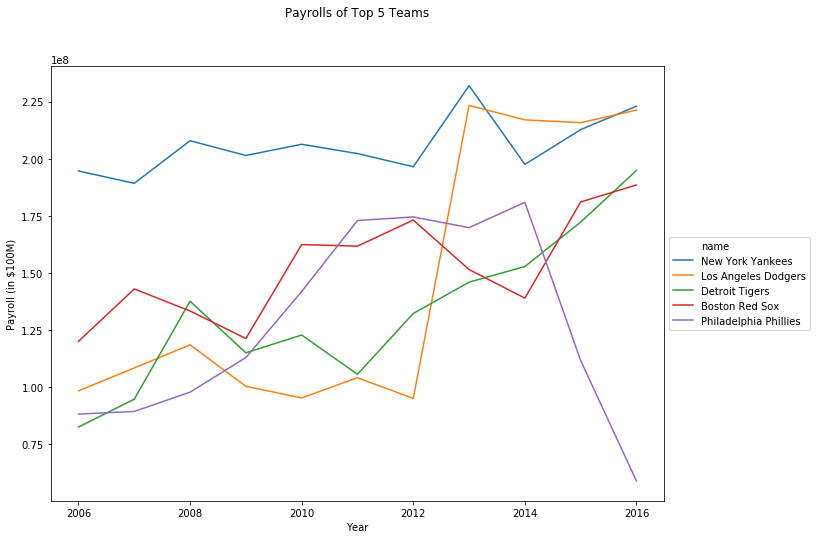

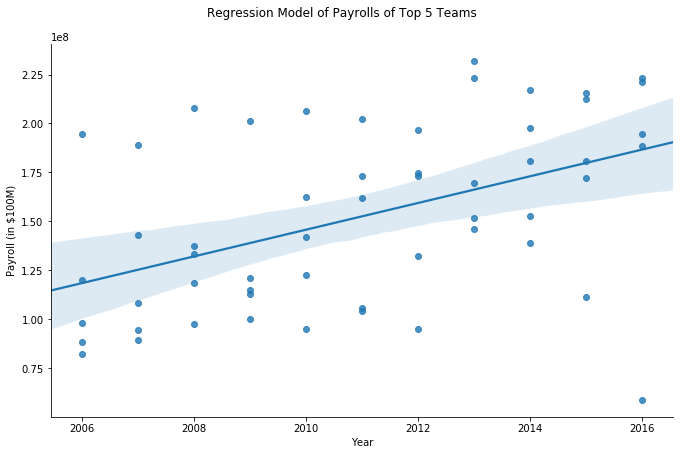

In [9]:
# plot teams payroll for smaller number of teams
makeplot("yearid", "payroll", top5, 
         "Payrolls of Top 5 Teams", 
         "Year",
         "Payroll (in $100M)",
         regplot = True, 
         cate_var = "name")

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff5ab6c5908>,
 <seaborn.axisgrid.FacetGrid at 0x7ff5ab4d4b70>)

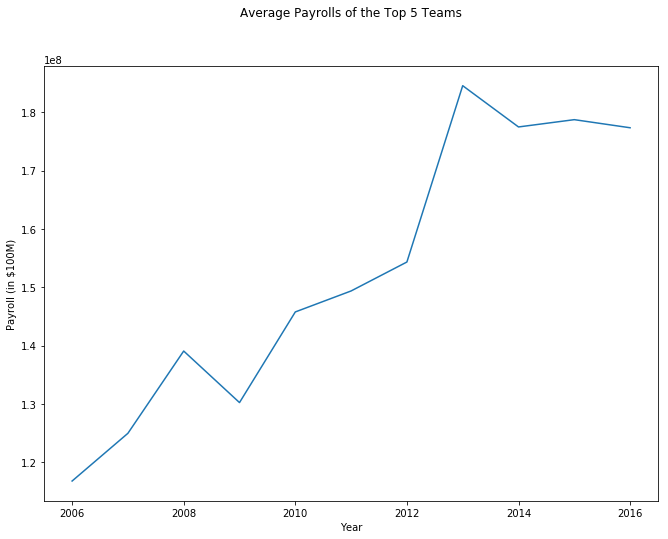

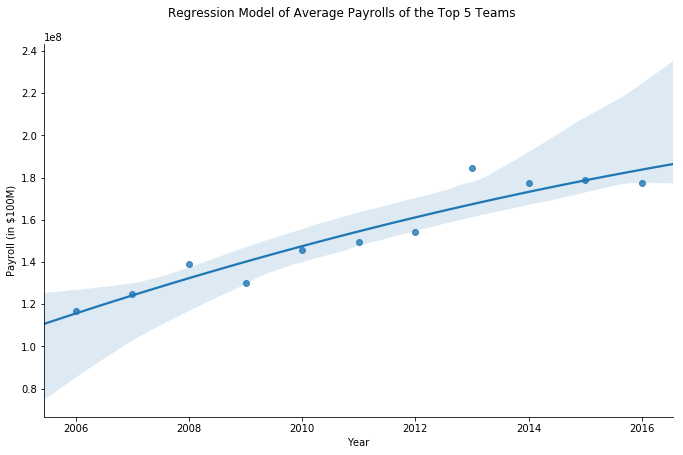

In [10]:
# make plot for average payroll over years
makeplot("yearid", "payroll", avg_5, 
         "Average Payrolls of the Top 5 Teams", 
         "Year",
         "Payroll (in $100M)",
         regplot = True,
         order = 2)

__Conclusion__

From the pathplot for the 5 teams with highest payroll, there is not a very clear trend of the payroll. While the payroll for teams other than the Philadelphia Phillies are generally increasing over years, the payroll for the Philadelphia Phillies descreased dramatically from 2014 to 2016. Therefore, we cannot reach a conclusion by looking at the pathplot. To get a general idea of the trend of the amount of payrolls for the 5 teams, a linear regression model is fitted. We can see that, although the regression model and both of the upper and the lower bound of its 95% confidence interval have a positive slope, the observations are scattered and does not have an obvious linear pattern, which indicates a weak linear relationship between payroll and year. Therefore, we can only conclude that, overall, teams payroll is increasing over years.

Further, since we care about the general trend of the overall payroll of the 5 teams, the average payroll for the 5 teams is calculated and plotted. From the second graph, we can see that the average payroll for all teams was initially increasing and decreased from 2013 to 2014 and eventually stablized since 2014. Since there is a potential change in trend from 2013 and on, a second order polynomial regression is fitted (instead of the linear regression model, which cannot show the change in slope). The fitted regression model shows a overall positive slope, which indicates that the payroll for the 5 teams is OVERALL increasing. However, noticing that the slope is decreasing with years, which indicates that the increasing trend of payroll is slowing down and have the potential pobability of turning into a decreasing trend.

However, since the average payroll from 2013 and on showed a decreasing trend, the conclusion about the overall pattern is only valid for the time period from 2006 to 2016. Further study should be conducted to add data from more recent years as well as data from year before 2006 to further test the trend of the payroll of these 5 teams.

__Exercise 1.1.3__

Based on the plots made from __exercise 1.1.2__, there are several abnomalities:
* First, the payroll increased dramatically for the Los Angeles Dodgers from 2012 to 2013.
* Second, the payroll decreased significantly for the Philadelphia Phillies from 2014 to 2016.
* Third, the payroll for the New York Yankees has a bump in 2013

__Explanation for the Abnomal Increase in the Payroll of the Los Angeles Dodgers from 2012 to 2013__

The most essential cause of the dramatic increase in payroll for the Los Angeles Dodgers is the switching of ownership happened in 2012 where the formal owner Frank McCourt sold the Dodgers to the Guggenheim Baseball Management LLC. As one of the first operations on the team made by the new owner, the Dodgers made a massive trade that involves nine players. 

The Los Angeles Dodgers acquired Josh Beckett, Adrian Gonzalez, Carl Crawford, and Nick Punto from this trade. From the [statista site](https://www.statista.com/statistics/236213/mean-salaray-of-players-in-majpr-league-baseball/), we can see that the average salary for a major league baseball player in 2013 is \\$3.39M. Looking at the salary of the players that Dodgers acquired, except Nick Punto, the other three players all have season salary well above \\$10M, not to mention that Gonzalez and Crawford both have season salary above \\$20M. From the active roster of the Dodgers after the trade, out of a total of 25 players, 7 of them are paid more than \\$10M-- 4 of these 7 players are paid over \\$20M. The total salary for these 7 players adds up to around $129M, which is already higher than the team payroll from 2012. In addition to the active roster, there are four players injured and the Dodger is also obligated to pay a salary for 10 players that are no longer on the team.

Therefore, because of the massive trade made by the new ownership, the Dodgers in 2013 has 7 players with an insanely high salary, a long list of injured player and dead money. All these factors resulted in a huge increase in team payroll for the Dodgers from 2012 to 2013. 

Sources:
* https://www.mlbtraderumors.com/2012/08/red-sox-dodgers-complete-nine-player-blockbuster.html
* https://www.statista.com/statistics/236213/mean-salaray-of-players-in-majpr-league-baseball/
* https://www.truebluela.com/2013/4/1/4169010/2013-dodgers-payroll-opening-day

__Explanation for the Abnomal decrease in the Payroll of the Philadelphia Phillies from 2014 to 2016__

The reason for the big fall of the Philadelphia Phillies' payroll is team rebuild. From sources as well as the plot made in exercise 1.1.2, we see that the Phillies has one of the highest payrolls in the early 2010s. The large payroll is caused by its core players, who reached their peaking earning years in the early 2010s. As mentioned in the [article](https://www.mlbtraderumors.com/2018/11/projecting-payrolls-philadelphia-phillies.html) from the MLB trade rumors, as a new team, the Phillies had some expensive veterans joined the team. Therefore, although the team's payroll is extremely high, the team did not have a lot of win in the early 2010s.

Normally, the fans and the ownership of a team with a high payroll would expect the team to be competitive and get a lot of wins. The unbalance between the Phillies' payroll and its number of wins made the ownership decided to rebuild the team. Therefore, in order to be able to make moves in the free agent market, the team then freed us its payroll starting 2015 and reached its all-time low at 2016. Used to be among the teams with the highest payroll, the Phillies quickly became a team among the 10 teams with the lowest payroll. 

Without long and large payer contract, the Phillies now have a very low payroll and a great financial flexibility that allows the team to rebuild and chase for good players in the free agency.

Souces:
* https://www.mlbtraderumors.com/2018/11/projecting-payrolls-philadelphia-phillies.html
* https://thatballsouttahere.com/2016/12/20/phillies-fifth-lowest-payroll-2016/
* https://www.philly.com/philly/blogs/sports/phillies/Phillies-payroll-fell-to-26th-in-MLB-last-season-.html

__Explanation of the Bump in Payroll for the New York Yankees in 2013__

By reading articles about the New York Yankees' payroll change in the early and mid-2010s, it turns out that it is not a bump in payroll in 2013, instead, it is a planned reduction in payroll in 2014. As we can see from the plot in exercise 1.1.2, the Yankees has been the team with the highest payroll for a long period of time-- starting from the beginning year of this study, 2006, and all the way to 2013 (the Yankees has the highest payroll from 1999 to 2013). The reason for such a high payroll is explained by this [article](https://www.nytimes.com/2012/03/02/sports/baseball/yankees-want-to-cut-payroll-to-189-million-by-2014.html) from the New York Times-- the New York Yankees has always aimed for competitiveness that they are willing to compromise the payroll for its competitiveness. 

The new luxury text policy that is going to be enforced in 2014, however, changed the Yankees strategy. In order to avoid a large amount of luxury tax, the ownership has set the goal for the general manager to cut the payroll of the team down to below the luxury tax threshold, \\$189M,  and this decision changed the overall increasing trend of the Yankees' payroll and result in a comparably large decreasing in payroll in 2014. Also, this decision terminated the Yankees' 8 year strike of having the highest payroll where the Dodgers' payroll in 2014 exceeded that of the Yankee's and became the team with the highest payroll.

Sources:
* https://www.cbssports.com/mlb/news/dodgers-break-yankees-streak-of-highest-opening-day-payrolls/
* https://www.nytimes.com/2012/03/02/sports/baseball/yankees-want-to-cut-payroll-to-189-million-by-2014.html

__Exercise 1.1.4__

In [11]:
# get the payroll for other teams (number of teams = LIMIT - 5 due to the dupication of top 5 teams)
data_other10 = pd.read_sql("""
    SELECT 
        yearid, payroll, name 
    FROM 
        byteam
    WHERE 
        class = "other_team"
    AND 
        name 
    IN
        (SELECT DISTINCT name FROM payroll LIMIT 15)    
""", db)

In [12]:
# get the average pay roll for other than the previous 5 teams
top5_n_avg = pd.read_sql("""
    SELECT 
        yearid, AVG(payroll) AS payroll, 
        CASE
            WHEN 
                class = 'other_team' 
            THEN 
                'other_team'
        END name, class
    FROM 
        byteam
    WHERE 
        class = 'other_team' 
    GROUP BY yearid
    UNION ALL
    SELECT 
        yearid, payroll, name, class
    FROM 
        byteam
    WHERE
        class = 'top5'
""", db)

In [13]:
# dataset of the average salary for top 5 teams and other teams
all_avg = pd.read_sql("""
    SELECT 
        yearid, AVG(payroll) AS payroll, class
    FROM 
        byteam
    GROUP BY class, yearid
""", db)

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff5ab61d400>,
 <seaborn.axisgrid.FacetGrid at 0x7ff5ab5537b8>)

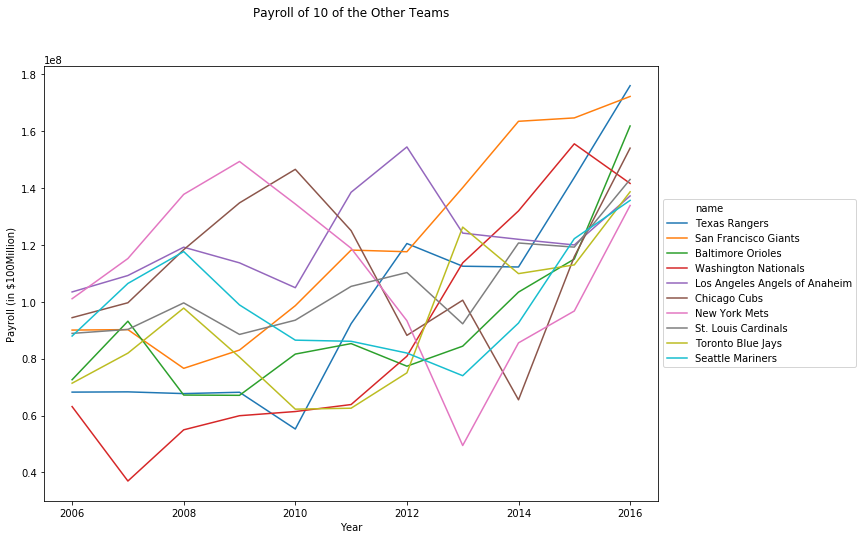

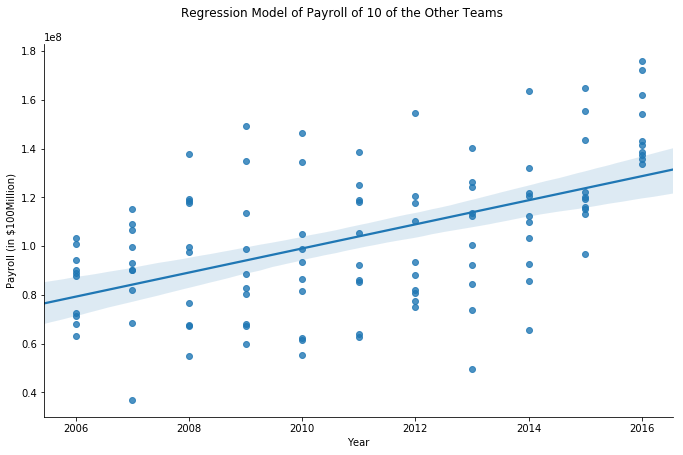

In [14]:
# plot of all payroll trends for other teams
makeplot("yearid", "payroll", data_other10, 
         "Payroll of 10 of the Other Teams", 
         "Year",
         "Payroll (in $100Million)",
         cate_var = 'name', 
         regplot = True)

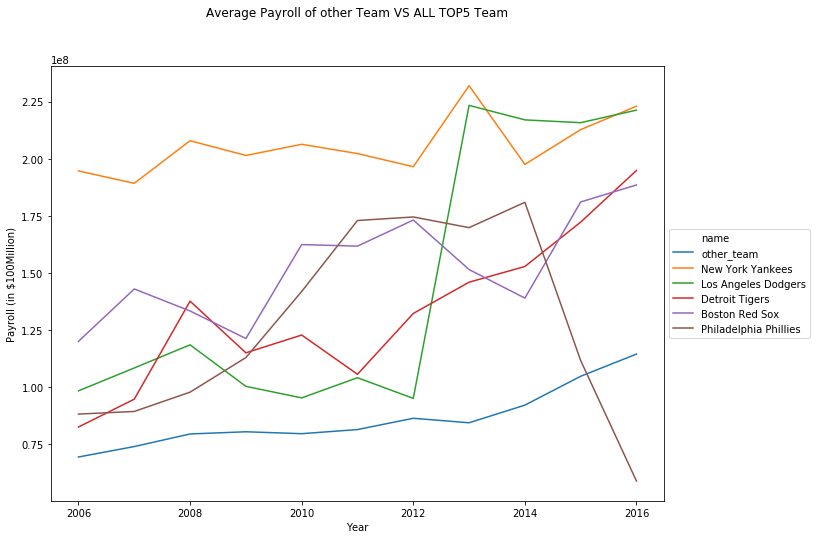

In [15]:
# plot compare the average payroll for other teams and the pay roll for top 5 teams
makeplot("yearid", "payroll", top5_n_avg, 
         "Average Payroll of other Team VS ALL TOP5 Team", 
         "Year",
         "Payroll (in $100Million)",
         cate_var = 'name')

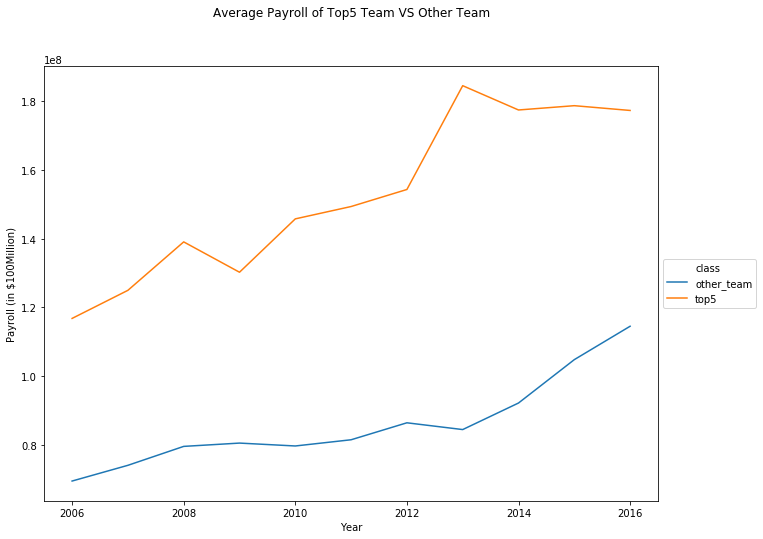

In [16]:
# plot of the average salary of top 5 teams VS other teams
makeplot("yearid", "payroll", all_avg, 
         "Average Payroll of Top5 Team VS Other Team", 
         "Year",
         "Payroll (in $100Million)",
         cate_var = 'class')

__Conclusion for Exercise 1.1.4__

In this exercise, a comparison is done between the top 5 teams and other teams in terms of payroll. To make the comparison clearer, the average payroll of the teams other than the top 5 is taken and is considered as a whole (denoted 'other teams'). 

__Comparison Between the Top 5 Teams__

First of all, a comparison of payroll paths within the top 5 teams is done. From the plot, we can see that 2008 is an interesting year in terms of payroll. Except for the Phillies, the other four teams' payroll all started to decrease after 2008. By further investigation, it turns out that there was a severe finicial crisis the hit the US market in 2008, which caused a huge impact on the global economy. Therefore, one plausible explanation for the payroll drop in 2008 is caused by the finicial crisis, where less people would investigate time or money in baseball and the team owners would have to cut down the spending in salary to make more revenue. One exception for this trend is the Phillies whose payroll is strongly increasing until the year of 2011 and then gradually turned into a rapid decreasing trend and this abnormality is discussed in prior section.

Before, the year of 2014, which is the year where the luxury tax started to apply to the teams, the Yankees are consistantly the team with highest payroll. After the luxury tax policy, the Dodgers became the team with the highest payroll, which is well above the threshold for luxury tax (\\$189M). In 2016, we can see that the payroll for the Yankees exceeded the Dodgers again. While the payroll for the Red Sox and Tigers increased gradually with small osccilations between years, the payroll for the Dodgers had an aggresive increase-- the payroll for the Dodgers in 2013 roughly doubled that of 2012 and made the Dodger the team with the highest payroll in 2014.  

After 2014, where the luxury tax policy started, the payroll for all four teams (except the Phillies) all started to increase again probably because of the inflated currency or the expansion of baseball market.

__Comparison Between the Top 5 Teams and "Other Teams"__

Before combining (taking average of) all "other teams", the general trend of payrolls for teams other than the top 5 teams is observed. In order to keep the plot clear and tidy, without loss of generality, a pathplot for 10 of the "other teams" is plotted to see the overall trend of these teams. As we can see from the first plot, unlike the payroll trend for the top 5 teams where there are ambiguities caused by the Philadelphia Phililes, the overall treand of the payroll paths for these 10 teams is clearly increasing. Although there are also teams whose payroll had a dramatic increase or decrease (for instance, the New York Mets), all paths after 2013 have a clear upward trend. The fitted linear regression model also proves this observation. Unlike the linear model for the top 5 teams where the obsservation are very scattered, the observations for "other teams" clearly have a stronger linear correlation between time and payroll. Therefore, the positive slope of the regression model as well as its 95\% confidence interval indicates that the overall trend of payroll for "other teams" is increasing. In addition, we can see from the plot of 10 teams that the at 2008, most teams' payroll also decreased potentially due to the US finicial crisis, which matched the pattern for the payroll of the top 5 teams.

After comparing the payroll path plot for 10 of the "other teams" with that of the top 5 teams, the average of payroll of all "other teams" is taken. From the second graph, the path of *"Otherteam"* is the average payroll plot for all "other teams". From the plot, we can observe that the average payroll for all "other teams" is significantly lower than any of the top 5 teams. As the matter of fact, it looks like the average payroll for "other teams" is roughly half of the payroll amount of any top 5 teams. Unlike the pathplots of the payroll for all the top 5 teams, the pathplot of the average payroll for "other team" is consistantly increasing and the slope of the plot is in an increasing trend whereas the payroll for the top 5 teams is not consistantly increasing and the increasing trend for the payroll of the top 5 teams is slowing down.

We can also see that the average payroll for "other team" after 2008, where the US finicial cirsis happened, although did not have an obvious decrease, is stablized and did not increase for the next 2 years, which is similar to the trend of payrolls of the top 5 teams during this time period.

__Exercise 1.2.__ Ask and use the database to answer 3 questions about baseball. For each question, write at least 2-3 paragraphs (~150 words) and support your answer with plots. If you feel like you don't have enough to write for a question, you probably aren't investigating follow up questions (inspired your original question) as carefully as you should.

__Try to come up with your own questions__, but here are two examples of reasonable questions:

* Is it common for players to switch teams? Has this changed over time? Which players have been on the most teams, and how many were they on?
* How much have salaries increased over the years in [real dollars](https://en.wikipedia.org/wiki/Real_versus_nominal_value_(economics))? The `salary` column in the `Salaries` table is in nominal dollars, so you will need to get Consumer Price Index data online if you want to answer this question. Is there a corresponding increase in performance?

Please make sure to clearly state each of your questions in your submission.

__Question 1__ Each year, the rookies who had outstanding performance will be awarded the "Rookie of the Year" award. Normally, winning the Rookie of the Year award indicates a good prospect of a player's professionl career. For players who have won the "Rookie of the Year" award between 2004 and 2006, investigate their salary from 2004 to 2016. Does the salary for award winners tend to increase or decrease? How's award winners salary compare to the average salary of the league? Conduct further investigation on any abnomalities found.

In [17]:
# make a dataframe contains salary for award winning players and the average player salary from 2004 to 2016
all_salary = pd.read_sql(""" 

    -- salary for award winning players
    
    SELECT
        l.yearid, 
        l.salary, 
        r.namefirst||' '||r.namelast AS name
    FROM
    (
    SELECT
        yearID, salary, playerid 
    FROM
        salaries 
    WHERE
        yearid BETWEEN 2004 AND 2016 
        AND playerid IN 
        (
        SELECT DISTINCT
            playerid 
        FROM
            (SELECT
                playerid,
                awardid,
                yearid,
                tie 
                FROM
                    awardsplayers 
            WHERE
                yearid BETWEEN 2004 AND 2006 
                AND awardid IN 
                ("Rookie of the Year")
            )
        )
    ) AS l 
    LEFT JOIN
        people AS r 
    ON l.playerid = r.playerid 

    UNION ALL
    
    -- average salary for all players
    
    SELECT 
        yearid, AVG(salary) AS salary, 
    CASE
        WHEN 
            yearid BETWEEN 2004 AND 2016
        THEN 
            'average'
    END name
    FROM 
        salaries 
    WHERE 
        yearid BETWEEN 2004 AND 2016
    GROUP BY yearid
""", db)

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff5a97c4a90>,
 <seaborn.axisgrid.FacetGrid at 0x7ff5a97193c8>)

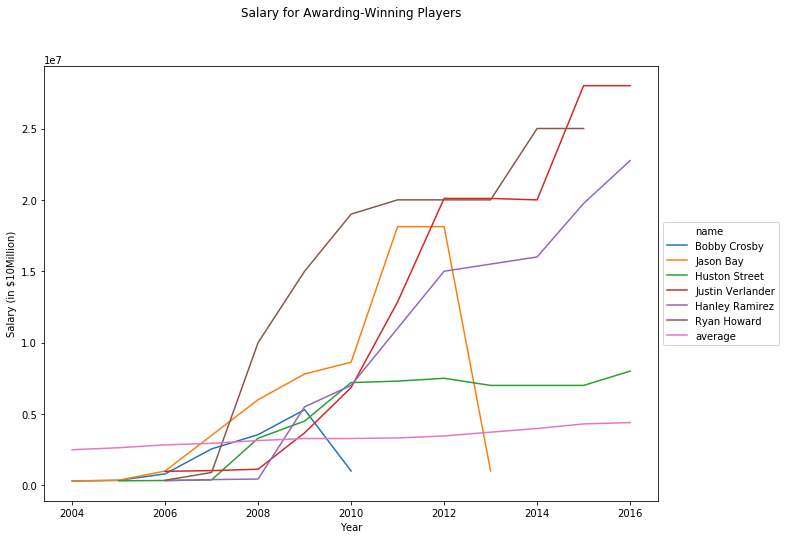

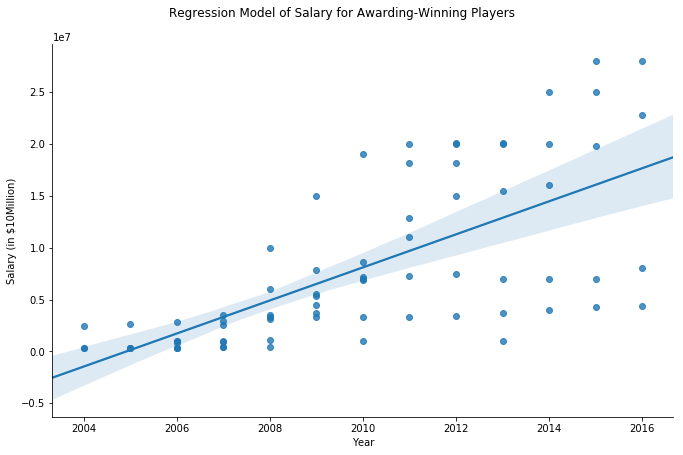

In [18]:
makeplot("yearID", "salary", all_salary, 
         "Salary for Awarding-Winning Players", 
         "Year",
         "Salary (in $10Million)",
         regplot = True,
         cate_var = "name")

__Conclusion for Question 1__

Between 2004 and 2006, there are a total of 6 players who won the "Rookie of the Year" __(ROY)__ award. The above plot records the salary change for ROY winners from 2004 and 2016. Note the not all paths go through the whole period, which indicates that there are players who quited the MLB prior to 2016. From the plot, we can see that the overall trend of the salary for these players is increasing, in a rather rapid pace. There  are two exceptions to this overall pattern and these two players will later be further investigated. We can also see a clearer trend from the fitted linear regression model. The fitted model as well as its 95% confidence interval all have a positive slope, which indicates that the salary for ROY ward winners is overall increasing. However, visually, the residual for our observations is gradually increasing over years, which is probably due to the fact that some player would sign long contract with teams, which will result in a more steady salary over a long period of time, while otehr players may decide to sign short contract, which is more likely to result in a faster increase in their salaries.

The pink line represents the average player salary in MLB from 2004 to 2016. Comparing the the average salary, we can see that the salary for all ROY winners exceeded the average salary by 2008, and, typically, their salary will exceed the league average within 1 to 4 years of winning the award. In addition, the plot also shows that the salary for 4 out of 6 ROY winners will exceed //$10 Million some time in their career, and 3 out of 6 ROY winners will have salary above \\$20 Million, which, according to result from exercise 1.1, is roughly the highest salary that a baseball player can get.

As mentioned before, there are two players that have abnormal salary path. Notice that the salary of Bobby Crosby and Jason Bay all have a dramatic decrease and both player quited their baseball career earlier than the other 4 players. Therefore, to figure out the causation of such abnormality, further investagtion is conducted on these two players:

* Bobby Crosby: Bobby Crosby won the Rookie of the Year award in 2004. Since then, however, Bobby has been suffered from injuries and was not able to perform well on the court, which resulted in him being traded to several teams and eventually being neglected by all the teams. Therefore, the abnormal salary path for Bobby Crosby is mainly caused by the unfortunate injury that happened right after he won the Rookie of the Year award. With injuries, Bobby still managed to play for 6 more years and eventually quited the league in 2010. 

    Sources:
    
    http://www.espn.com/mlb/news/story?id=3958018 
    
    https://en.wikipedia.org/wiki/Bobby_Crosby
    
    
* Jason Bay: Unlike Bobby who never had a high salary season, Jason Bay had salary above \\$15Million from 2011 to 2012. Also the Rookie of the Year award winner in 2004, Jason performed very well since winning the award and played for several teams with great preformance on every one of them. Jason then agreed to a four-year, \\$66 million contract with the New York Mets, which is the big leap in salary from 2010 to 2011 and 2012. Similar to Bobby, Jason Bay suffered several injuries after joining the METs. He had a concussion in a game against the Dodgers and a rib injury put him on the disabled list. After returning, Jason sturggled on the court, which caused dissatisfaction in the ownership of the New York Mets. To free up payroll, the New York Mets negotiated with Jason and ended his contract two year early in 2012. Jason then joined the Seattle Mariners with salary \\$1M in 2013, which explains the big drop in salary from 2012 to 2013. Unable to fully recover from the injury, Jason evetually quited the MLB after 2013.

    Sources:
    
    http://www.espn.com/new-york/mlb/story/_/id/8603765/jason-bay-contract-new-york-mets-terminated-early
    
    https://en.wikipedia.org/wiki/Jason_Bay#cite_note-15

__Question 2__

From 1933, the MLB league will hold an All-Star baseball game once a year (occasionally twice a year) where star players selected from the AL (American League) league will play against the star players selected from the NL (National League) league. The players in the All-star roster are selected by the fans and are usually very outstanding and famous baseball players. Therefore, whether a player has ever played an All-star game is one way to measure his still. In this question, investigate the number of All-star player that each college team have ever trained from 1948 to 2018. Are there colleges with more than one All-star alumni? If so, what are those colleges. Provide a college ranking based on the number of All-star players ever played for the team. Compare the ranking based on number of All-star players with ranking from other sources. Is "the number of All-star player on college team" a good way to measure the competitiveness of college teams? Provide a comprehensive guide for highschool students who want to play professional baseball on what college teams should they be applying to.

In [19]:
allstar = pd.read_sql("""
    SELECT 
        r.schoolid,
        r.name_full AS name,
        COUNT(name_full) AS count,
        r.state
    FROM
    (
    SELECT DISTINCT 
        l.playerid, r.schoolid 
    FROM
    (
    SELECT 
        playerid, yearid
    FROM 
        allstarfull
    WHERE
        yearid BETWEEN 1948 AND 2018
    ) AS l
    LEFT JOIN
    (
    SELECT 
        playerid, schoolid, yearid
    FROM
        collegeplaying
    WHERE
        yearid BETWEEN 1948 AND 2018
    ) AS r
    ON
        l.playerid = r.playerid 
    WHERE
        schoolid != 'None'
    ) AS l
    LEFT JOIN
    (
    SELECT 
        schoolid, name_full, state
    FROM 
        schools
    ) AS r
    ON 
        l.schoolid = r.schoolid
    GROUP BY (name_full)
    ORDER BY count DESC
    LIMIT 25
""", db)

__Scrape a table of ESPN/USA Today Coaches Poll as supplimentary material__

In [20]:
# scrape table of ESPN/USA Today Coaches Poll ranking from Wikipedia 
tabs = pd.read_html("https://en.wikipedia.org/wiki/2018_NCAA_Division_I_baseball_rankings")
tbl = tabs[2]

# clean up data from scraped table
tbl = pd.DataFrame({'ESPN/USA Today Coaches Poll': tbl.iloc[1:26,15]})
tbl.loc[:,'ESPN/USA Today Coaches Poll'] = [ele.split("(")[0].strip() for ele in tbl.loc[:,'ESPN/USA Today Coaches Poll']]

In [21]:
multi_table([allstar.sort_values('schoolid'), tbl.sort_values('ESPN/USA Today Coaches Poll')])

,schoolid,name,count,state
1,arizonast,Arizona State University,16,AZ
21,auburn,Auburn University,5,AL
7,calstfull,California State University Fullerton,7,CA
23,casacra,Sacramento City College,5,CA
24,flmanat,"State College of Florida, Manatee-Sarasota",5,FL
22,floridast,Florida State University,5,FL
9,gatech,Georgia Institute of Technology,7,GA
8,longbeach,California State University Long Beach,7,CA
5,lsu,Louisiana State University,8,LA
2,miamifl,University of Miami,10,FL


__Conclusion for Question 2__

__PART I. Analysis on the Ranking made by number of All-star Players__

Above is the list of the top 25 universities that had the largest number of All-star player played at when they are in college. From the list, we can see that there are numerous universities that have trained more than one All-star players. According to the ranking, we can see the that University of Southern California has trained the largest number of All-star players, which, in this aspective, indicates that it is the best fit for students who want to play professional baseball in the future. Besides the University of Southern California, the Arizona State Universit is also very competitive in terms of number of All-star players. Being ranked in the second palce, the Arizona State University trained 16 All-star players which is still a very large number compare to that of other universities. Therefore, the Arizona State University is also one of the best choice for future basebell atheletes. The number of All-star player for universities ranked 3 to 25 does not vary a lot. Therefore, these universities are also great choices for future baseball atheletes but we are not able to distinguish the competitiveness of their baseball programs due to the less of variation in All-star player between these universities. Therefore, in order to distinguish the competitiveness of baseball programs of universities that are ranked 3 to 25 and to ensure that "number of All-star alumni" is a reasonable factor to judge the competitiveness of college baseball program, ranking made by the ESPN/USA Today Coaches Poll is used to further investigate college baseball progarms.

__Strategy for Part II__

The strategy used here is to find the intersection between the ranking based on All-star player and the 2018 edition of ESPN/USA Today Coaches Poll. Initially, an attemption to find the intersection of these two rankings by codes is done. Due to the differnt names that the two rankings use for college, this attemption failed and the most efficitn method here is to order the two datasets and then find the intersection by eye.

__PART II. Comprehensive Analysis Based on two Rankings__
Based on both tables, we can see that the Universities that have both a large number of All-star alumnis and good ranking in the most current report are:

* Aburn University
* California State University Fullerton 	
* Florida State University
* University of Minnesota
* Mississippi State University 	
* Stanford University 	
* University of Texas at Austin 	
* University of North Carolina at Chapel Hill 	
* Vanderbilt University

Since these universities have both a large number of All-star alumni and are ranked in the top 25 college baseball teams by the ESPN/USA Today Coarches Poll, we can safely conlcude that these universities definitly have some of the most competitive baseball programs in the country. On the other hand, the baseball programs in the following universities are also competitive:

* University of Southern California
* Arizona State University
* Oregon State University
* University of Arkansas

Although these universities only appeared in one of the two rankings, they are the top 2 teams in each ranking. Both the Arizona State University and the University of Southern California have around 20 All-star alumnis, which indiated these two college teams are historically competitive. On the other hand, the baseball team of the Oregon State University and the University of Arkansas are rated the best and the second best team by the ESPN/USA Today Coarches Poll in 2018, which indicates that, althought they may not be as competitive as the previous two universities historically, the baseball teams for these two universities are currently the best team in the US.

To conclude, accroding to the number of All-star alumnis and the team ranking in 2018, these 13 universities are the best choices for students who want to play professional baseball in the future (Order doesn;t matter):

* Arizona State University
* University of Southern California
* Oregon State University
* University of Arkansas
* Aburn University
* California State University Fullerton 	
* Florida State University
* University of Minnesota
* Mississippi State University 	
* Stanford University 	
* University of Texas at Austin 	
* University of North Carolina at Chapel Hill 	
* Vanderbilt University 	

__Question 3__

Winning the World Series champion is the ultimate goal for each team in the MLB. To achieve this goal, every team has their own approach and strategy. Some teams increase their competitiveness by acquiring more and more star player while other teams may increase their competitiveness by adjusting their play designs. Between 2006 and 2016, find out which teams have won the world series champion in these 10 years. Which team is the most efficient with their payroll? Which team has the least amount of star players? Does the any of the five teams that had the highest payroll bewteen 2006 and 2016 won the world series championship? 

Extra INFO:

* The average salary for all-star players from both AL and NL leagues is \\$6M
* The average inflation rate from 2006 to 2016 is 2.1\%. Use this information to convert nominal money to real money

Sources: 

Salry:

https://www.forbes.com/sites/blakewilliams3012/2017/07/11/3-numbers-to-know-about-the-salaries-of-the-nl-all-stars/#b844b0e174d7

Inflation Rate: 

https://www.minneapolisfed.org/community/financial-and-economic-education/cpi-calculator-information/consumer-price-index-and-inflation-rates-1913

In [22]:
champ = pd.read_sql("""
    SELECT l.*, r.allstar FROM
    (
    SELECT 
        l.*, 
        r.payroll
    FROM
    (
    SELECT 
        yearid, teamid, name 
    FROM 
        teams 
    WHERE 
        wswin = 'Y' 
    AND 
        yearid BETWEEN 2006 AND 2016
    ) AS l
    LEFT JOIN
        payroll AS r
    ON
        l.teamid = r.teamid
    AND
        l.yearid = r.yearid
    ) AS l
    LEFT JOIN
    (
    SELECT 
        yearid, teamid, COUNT(playerid) AS allstar 
    FROM 
        salaries
    WHERE 
        yearid BETWEEN 2006 AND 2016
    AND
        salary > 6000000
    GROUP BY teamid, yearid
    ) AS r
    ON l.yearid = r.yearid AND l.teamid = r.teamid
    ORDER BY l.payroll DESC, r.allstar DESC
""", db)

__Adjust Inflation and Calculate Real Money__

In [23]:
# adjust payroll with inflation and reorder dataframe
champ.loc[:,'payroll2016'] = champ.loc[:,'payroll'] * 1.021 ** abs(champ.loc[:,'yearid'] - 2016).round()

champ.sort_values(['payroll2016', 'allstar'], ascending = False)

,yearid,teamid,name,payroll,allstar,payroll2016
0,2009,NYA,New York Yankees,201449189,10,232994526
4,2007,BOS,Boston Red Sox,143026214,10,172443696
1,2014,SFN,San Francisco Giants,163510167,9,170449702
3,2013,BOS,Boston Red Sox,151530000,9,161278268
2,2016,CHN,Chicago Cubs,154067668,9,154067668
5,2012,SFN,San Francisco Giants,117620683,5,127816425
7,2011,SLN,St. Louis Cardinals,105433572,7,116978926
9,2008,PHI,Philadelphia Phillies,97879880,7,115584438
6,2015,KCA,Kansas City Royals,112107025,9,114461273
8,2010,SFN,San Francisco Giants,98641333,5,111741214


__Conclusion For Question 3__

The above table listed the teams that have won the world series championship from 2006 and 2016. Also, since we are looking at teams with a 11 year time span, the payroll of each team is adjusted according to average inflation rate from 2006 to 2016. Besides, the *allstar* column is the number of all-star players on the team in the specific year. The number of allstar player is calculated according to their salary.

From the table, we see that the champion team with the least amount of payroll is the St. Louis Cardinals, who won the world championship in 2006. In addition, correponding to the comparably low amount of payroll, the St. Louis Cardinals also have the least amount of star players on their team, which is 5. Compare to the Boston Red Sox, which has won the word series in 2007, we can see that the adjusted payroll of the St. Louis Cardinals is almost \\$60 Millions less than that of the Boston Red Sox and the number of allstars on the Boston Red Sox is double the number of St. Louis Cardinals. Therefore, we can see that the St. Louis Cardinals is very efficient with their money and the strategy they used to win the championship is more likely to be efficient play designs instead of gethering star players.

On the other hand, the New York Yankees which is the world champion of 2009 has the highest amount of payroll among all these 11 teams. After adjusting for inflation, the New York Yankees' payroll is \\$232 Millions, which is almost \\60 Millions$ more than the second highest team, the Boston Red Sox from 2007, and more than twice the payroll amount of the St. Louis Cardinals. With the information get from question 1.1.3, we can see that the strategy for the New York Yankees, as mentioned by its general manager, is indeed competitiveness over payroll. With the highest payroll, the New York Yankees won the world series Champions with 10 all star players on its team, which is the largest number of all star players in this list. 

In addition, out of the 5 teams that had the highest payrolls between 2006 to 2016, only the Los Angeles Dodgers and the Detroit Tigers have not won a world series champion in these 11 years, which indicates that the ownership and the general manager for these two teams are not as efficient as the other teams.

In conclusion, we can see that in order to win a world championship, a team does not neccesarily need to have a large payroll. Teams such as the St. Louis Candinals, the San Francisco Giants, the Kansas City Royals, etc. all have won a world championship with a reasonable amount of payroll. In addition, team with a large amount of payroll will not neccessarily win the world championship. For example, the New York Yankees has the largest amount of payroll in 8 of the 11 years from 2006 to 2016, but it only has won 1 world championship in these years. On the other hand, we can also see from this plot that in order for a team to win the world series champion, it generally needs to have at least 5 all star players. Also, it appears that team located in major cities like New York and Boston generally have a bigger chance of winning the world series as 8 out of 11 champions are teams that are located in major cities (New York, Boston, San Francisco, Chicago, Philadelphia).

In [24]:
# close database connection
db.close()